# Financial Fraud Detection

### The Data
The data used for this analysis is a synthetically generated digital transactions dataset using a simulator called PaySim. PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. It aggregates anonymized data from the private dataset to generate a synthetic dataset and then injects fraudulent transactions.<br><br>
View data here: https://www.kaggle.com/datasets/ealaxi/paysim1<br><br>
Class variable: `isFraud`

In [376]:
import pandas as pd
from IPython.display import display

df = pd.read_csv('fraud-detection-syn-dataset.csv')
del df['isFlaggedFraud']

df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


### Data Cleaning

In [377]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

Now, we get the summary statistics of this `pandas dataframe` which will be done in two bits:
1. Summary of 'Numerical' attributes:

In [378]:
desc_df_num = df.describe([.25, .5, .75])
desc_df_num

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


2. Summary of 'Categorical' columns:<br><br>
In this section only the count, unique values and mode of data hold importance.

In [379]:
desc_df_cat = df.describe(include="object")
desc_df_cat

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


Now we move forward to check for missing values in our dataset, and handle them depending on the number of missing values, column-wise.

In [380]:
df.isnull().values.any()

False

The output of the above code block suggest are no `nulls` in our dataset.

### Exploratory Data Analysis

As can be seen from the above <b>table</b> `desc_df_cat`, the number of legitimate (<b>non-fraudulent</b>) transactions (`isFraud = 0`) is very high compared to the fraudulent ones.


In [381]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

We only have `~0.13%` fraudulent transactions in our dataset (as would be the case in the real world), which creates an <b><i>imbalance</i></b> in our class variable `isFraud` —> <b>Class Imbalance</b>.

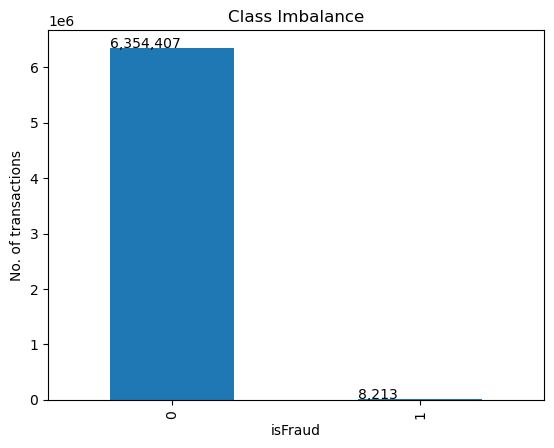

In [382]:
import matplotlib.pyplot as plt

axes = pd.value_counts(df['isFraud'], sort = True).sort_index().plot(kind = 'bar', title = 'Class Imbalance')

for p in axes.patches:
    axes.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    axes.set_xlabel('isFraud')
    axes.set_ylabel('No. of transactions')
plt.show()

As we can see from these results, our class variable contains data which is highly skewed towards the <i>flag</i> value `0`, which would indeed affect any models we might <b>train</b> on this dataset.

Moving on to the attribute `type`—types of transactions:

In [383]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

<Axes: >

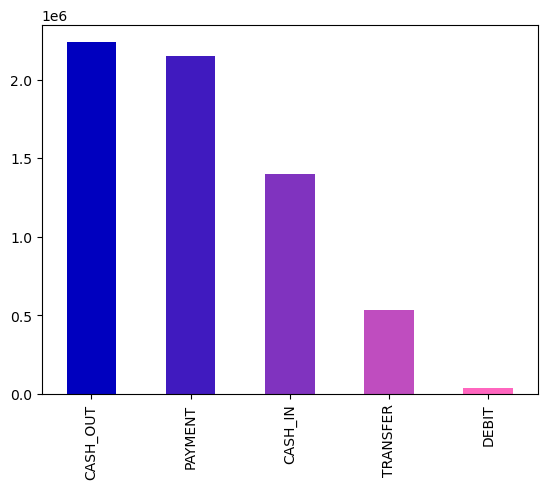

In [384]:
plotColours = [(x/4, x/10, 0.75) for x in range(10)]
df['type'].value_counts().plot.bar(color = plotColours)

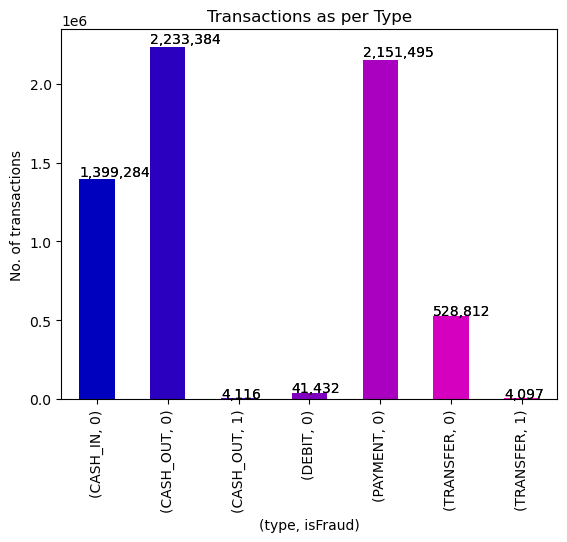

In [385]:
plotColours = [(x/6, x/10000, 0.75) for x in range(10)]
axes = df.groupby(['type', 'isFraud']).size().plot.bar(color = {'violet', 'green', 'purple', 'orange', 'teal', 'brown'})
axes = df.groupby(['type', 'isFraud']).size().plot.bar(color = plotColours)
axes.set_title('Transactions as per Type')
axes.set_xlabel('(type, isFraud)')
axes.set_ylabel('No. of transactions')
for p in axes.patches:
    axes.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

This plot shows us that only `type` `CASH_OUT` and `type` `TRANSFER` transactions can be <i>fraudulent</i>, and we can therefore remove the entries which have a different transaction `type`.

In [386]:
df = df.loc[~(df['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT']))]
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1


Only the transactions of `CASH_OUT type` and `TRANSFER type` are retained in out dataframe now, and the updated dataframe now has a total of `2770409` transactions, the data which earlier had `>6mil` tuples.<br><br>
We shall now check the percentge of <i>fraudulent</i> transactions shared among these two categories for a better understanding of the distribution of the same.

CASH_OUT    0.501157
TRANSFER    0.498843
Name: type, dtype: float64

<Axes: ylabel='type'>

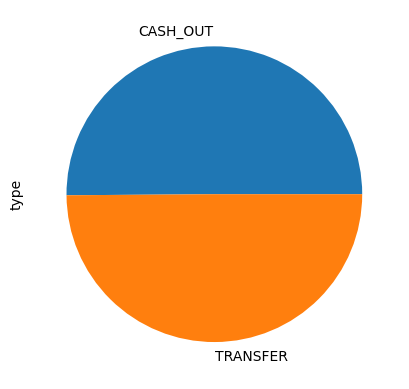

In [387]:
data_fraud = df[df.isFraud == 1] 
display(data_fraud.type.value_counts(normalize=True))
data_fraud.type.value_counts().plot.pie()

As can be seen from the above chart and figures, `isFraud = 1` transactions are almost equally distributed among `type CASH_OUT` and `TRANSFER` in the ratio `0.501:0.499`.

Now we will move on to checking the transactions where `amount` is `zero`.

In [388]:
df_zeroAmtTxns = df.loc[df['amount'] == 0]
len(df_zeroAmtTxns), df_zeroAmtTxns[['type', 'isFraud']]


(16,
              type  isFraud
 2736447  CASH_OUT        1
 3247298  CASH_OUT        1
 3760289  CASH_OUT        1
 5563714  CASH_OUT        1
 5996408  CASH_OUT        1
 5996410  CASH_OUT        1
 6168500  CASH_OUT        1
 6205440  CASH_OUT        1
 6266414  CASH_OUT        1
 6281483  CASH_OUT        1
 6281485  CASH_OUT        1
 6296015  CASH_OUT        1
 6351226  CASH_OUT        1
 6362461  CASH_OUT        1
 6362463  CASH_OUT        1
 6362585  CASH_OUT        1)

There are `16` such transactions, the `type` for all of them is `CASH_OUT`, and all of these transactions are `FRAUDULENT`.
<br><br>
We now shall move on to analyzing the originators' & recipients' balances.
Finding the number of transactions where `oldbalanceOrg` or `newbalanceDest` `=0`:

In [389]:
f"`oldbalanceOrg` == 0: {round(len(df.loc[df['oldbalanceOrg'] == 0])*100/len(df), 2)}%, `newbalanceDest` == 0: {round(len(df.loc[df['newbalanceDest'] == 0])*100/len(df), 2)}%" 

'`oldbalanceOrg` == 0: 47.23%, `newbalanceDest` == 0: 0.6%'

It is seen that in almost half of the transactions, the originator's initial balance was recorded as `zero`.
<br><br>
In an ideal scenario, the `newbalanceDest == oldbalanceDest + amount`, and `newbalanceOrig == oldbalanceOrg - amount`. We will now check these conditions.

In [390]:
df.loc[df['newbalanceOrig'] != df['oldbalanceOrg'] - df['amount']]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.0,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.0,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.0,2719172.89,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.00,C1509514333,288800.0,2415.16,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.00,C824009085,70253.0,64106.18,0
...,...,...,...,...,...,...,...,...,...,...
6362462,730,TRANSFER,7316255.05,C1869569059,17316255.05,17316255.05,C1861208726,0.0,0.00,1
6362506,734,TRANSFER,10000000.00,C1891630790,11810044.85,1810044.85,C2124431731,0.0,0.00,1
6362528,736,TRANSFER,10000000.00,C412961249,11314660.84,1314660.84,C253674970,0.0,0.00,1
6362582,741,TRANSFER,10000000.00,C1945606464,15674547.89,5674547.89,C625944676,0.0,0.00,1


In [391]:
f"Txns. where Originators' balances are not accurately captured: {round((len(df.loc[df['newbalanceOrig'] != df['oldbalanceOrg'] - df['amount']])*100/len(df)), 2)}%"

"Txns. where Originators' balances are not accurately captured: 93.72%"

In [392]:
f"Txns. where Recipients' balances are not accurately captured: {round((len(df.loc[df['newbalanceDest'] != df['oldbalanceDest'] + df['amount']])*100/len(df)), 2)}%"

"Txns. where Recipients' balances are not accurately captured: 42.09%"

So, in most transactions, Originators' balances are not accurately captured, and in about two-fifths of the transactions, the Recipients' balances are not accurately captured.

Now, we will explore if any of the variables directly help us identify the `FRAUDULENT` transactions.
<br>
##### 1. Time `step` variable:
The number of txns. in each time `step` along with the `isFraud` flag is to be measured to identify (if any) the time steps where there are higher number of fraudulent transactions.

In [393]:
df[['step', 'isFraud']]

,step,isFraud
2,1,1
3,1,1
15,1,0
19,1,0
24,1,0
...,...,...
6362615,743,1
6362616,743,1
6362617,743,1
6362618,743,1


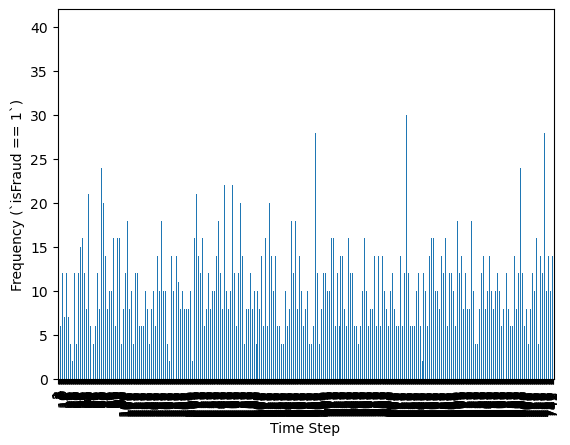

In [394]:
df_fraud = df['isFraud'].isin([1])

fraud_time = df[df_fraud].groupby(['step']).size().plot(kind='bar')
fraud_time.set_xlabel('Time Step')
fraud_time.set_ylabel('Frequency (`isFraud == 1`)')
plt.show()

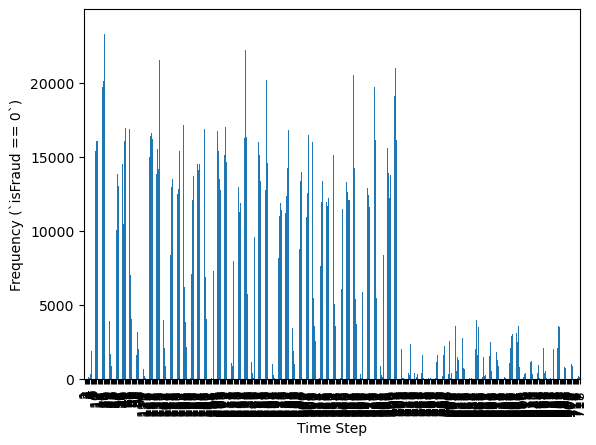

In [395]:
df_fraud = df['isFraud'].isin([0])

fraud_time = df[df_fraud].groupby(['step']).size().plot(kind='bar')
fraud_time.set_xlabel('Time Step')
fraud_time.set_ylabel('Frequency (`isFraud == 0`)')
plt.show()

Here, we can see that though the `FRAUDULENT` transactions are uniformly spread across `time`, the `NON-FRAUDULENT` trasactions are more concentrated in specific `time steps`.
<br>
##### 2. Transaction `amount` variable:
We will now try to find out if there lies any relationship between `isFraud` and the transacrtion `amount`:

In [396]:
df['amount']
df_fraud = df['isFraud'].isin([0])
df_fraud
df.amount

2              181.00
3              181.00
15          229133.94
19          215310.30
24          311685.89
              ...    
6362615     339682.13
6362616    6311409.28
6362617    6311409.28
6362618     850002.52
6362619     850002.52
Name: amount, Length: 2770409, dtype: float64

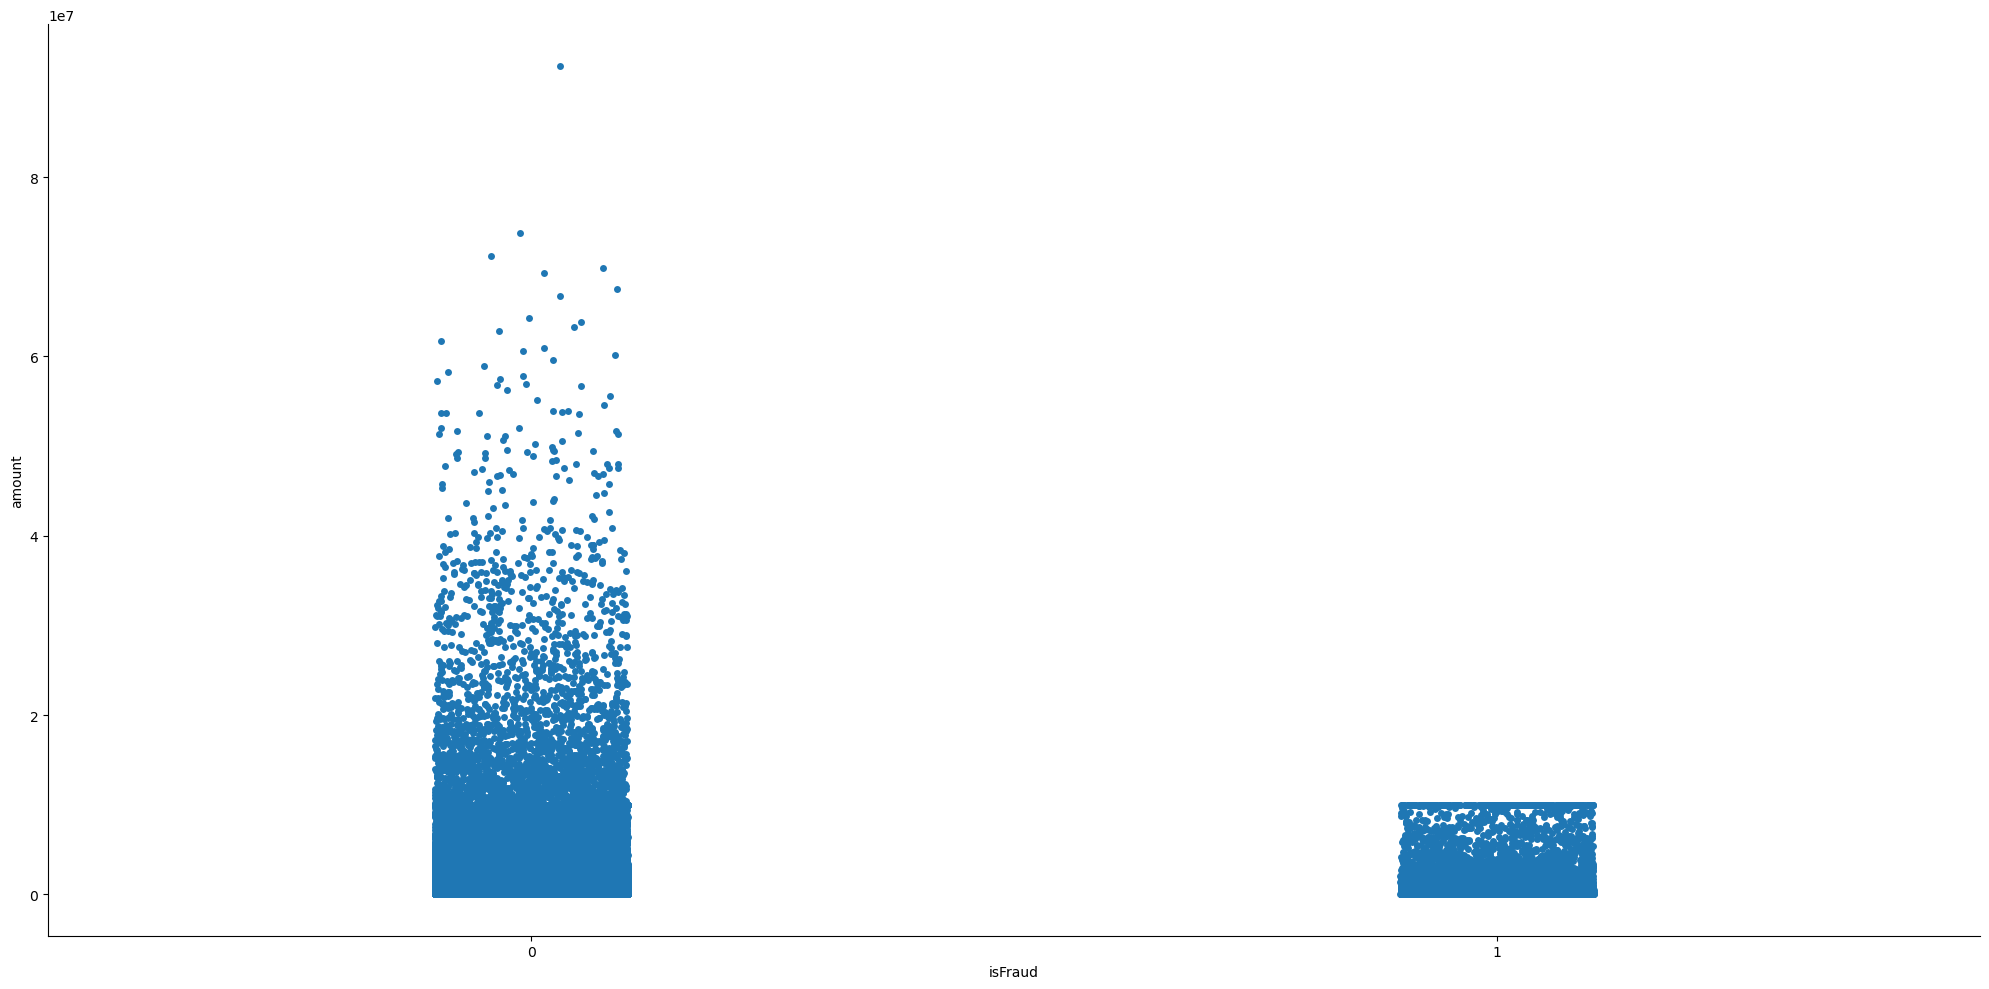

In [397]:
import seaborn as sns

sns.catplot(data=df, x = df.isFraud, y = df.amount, height = 10, aspect = 2)

Here, we can see that the amount of `Non-fraudulent` transactions can be little higher that the `fraudulent` ones, however nothing can be derived about the differences between the two based on `amount`.
<br>
##### 3. Balance variables:
We have already seen that there is a relationship between `fraudulent` transactions and `amount = 0`. We have also seen that a high number of transactions have inaccurately collected initial and final balances. Let us check these inaccuracies:

In [398]:
df['origBalance_inacc'] = (df['oldbalanceOrg'] - df['amount']) - df['newbalanceOrig']
df['destBalance_inacc'] = (df['oldbalanceDest'] + df['amount']) - df['newbalanceDest']

df[['origBalance_inacc', 'destBalance_inacc']]

/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_29498/2492156372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['origBalance_inacc'] = (df['oldbalanceOrg'] - df['amount']) - df['newbalanceOrig']
/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_29498/2492156372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['destBalance_inacc'] = (df['oldbalanceDest'] + df['amount']) - df['newbalanceDest']


,origBalance_inacc,destBalance_inacc
2,0.00,1.810000e+02
3,0.00,2.136300e+04
15,-213808.94,1.827035e+05
19,-214605.30,2.377353e+05
24,-300850.89,-2.401220e+06
...,...,...
6362615,0.00,0.000000e+00
6362616,0.00,6.311409e+06
6362617,0.00,1.000000e-02
6362618,0.00,8.500025e+05


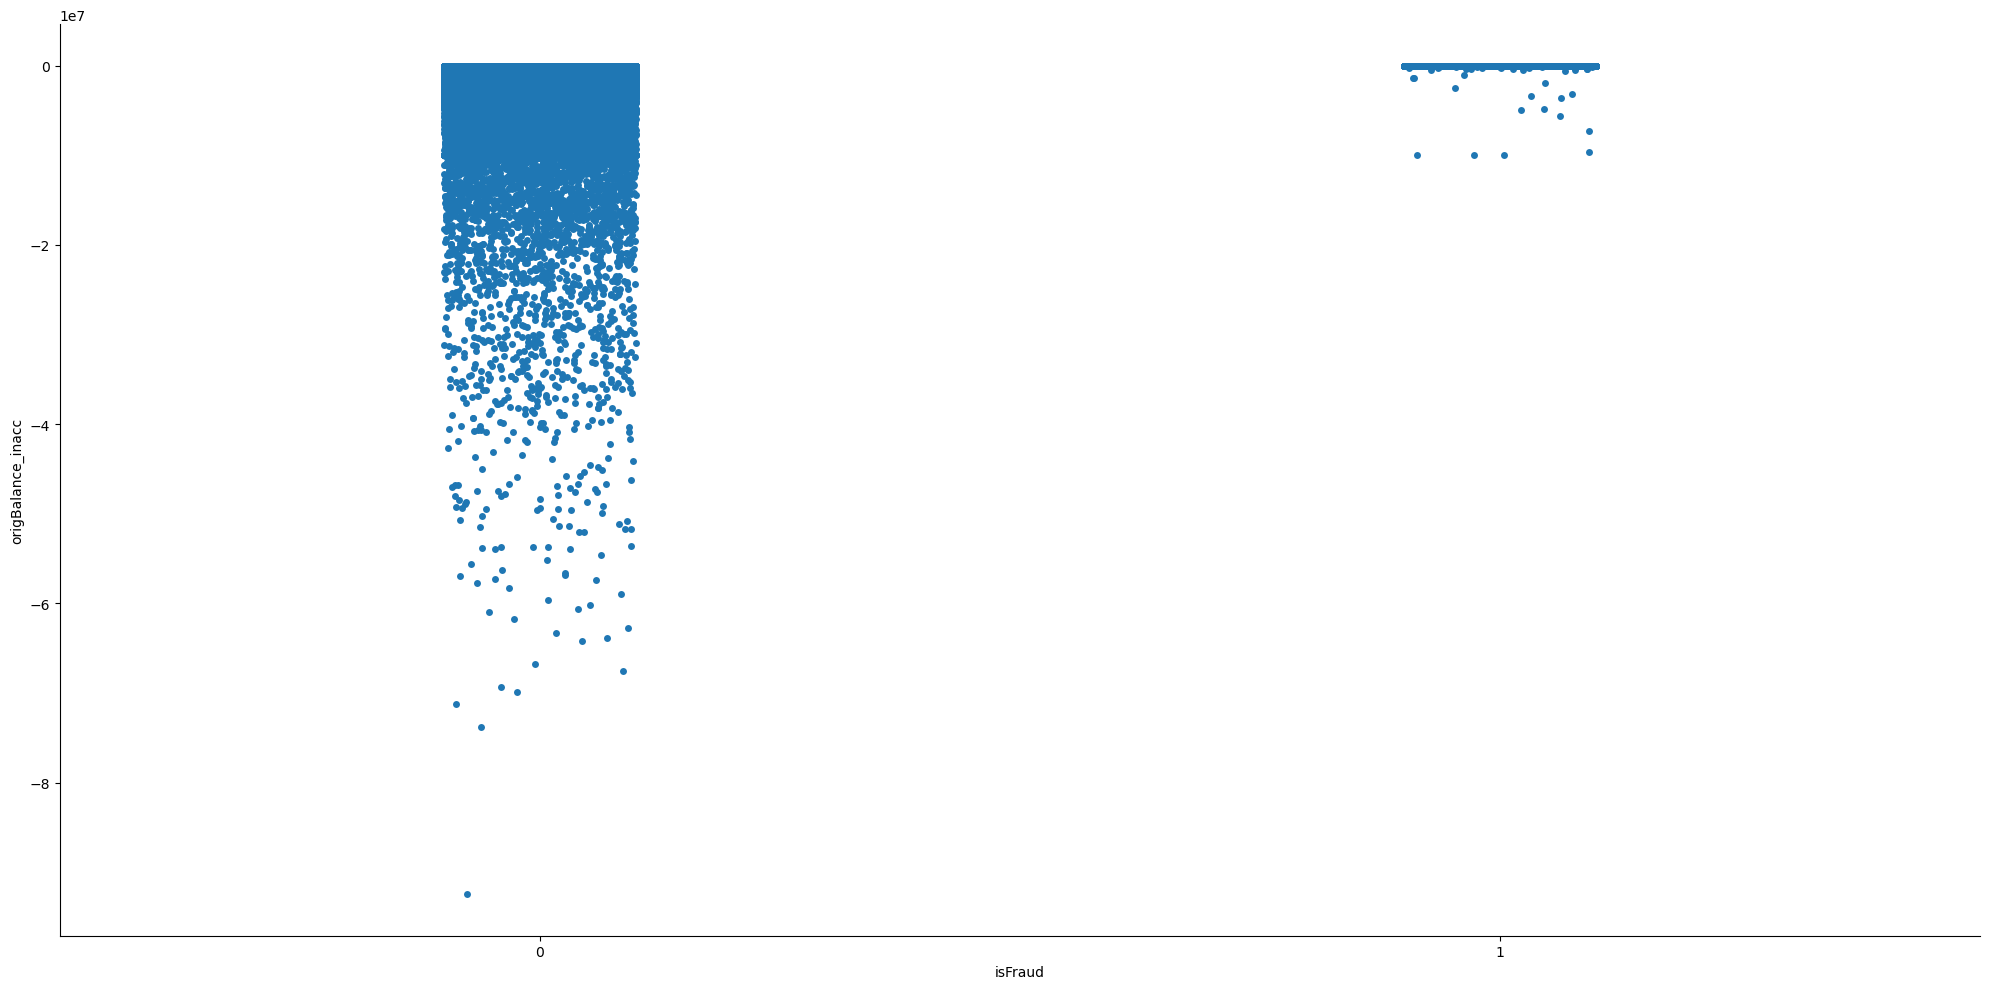

In [399]:
sns.catplot(data=df, x = df.isFraud, y = df.origBalance_inacc, height = 10, aspect = 2)

<Figure size 2000x500 with 0 Axes>

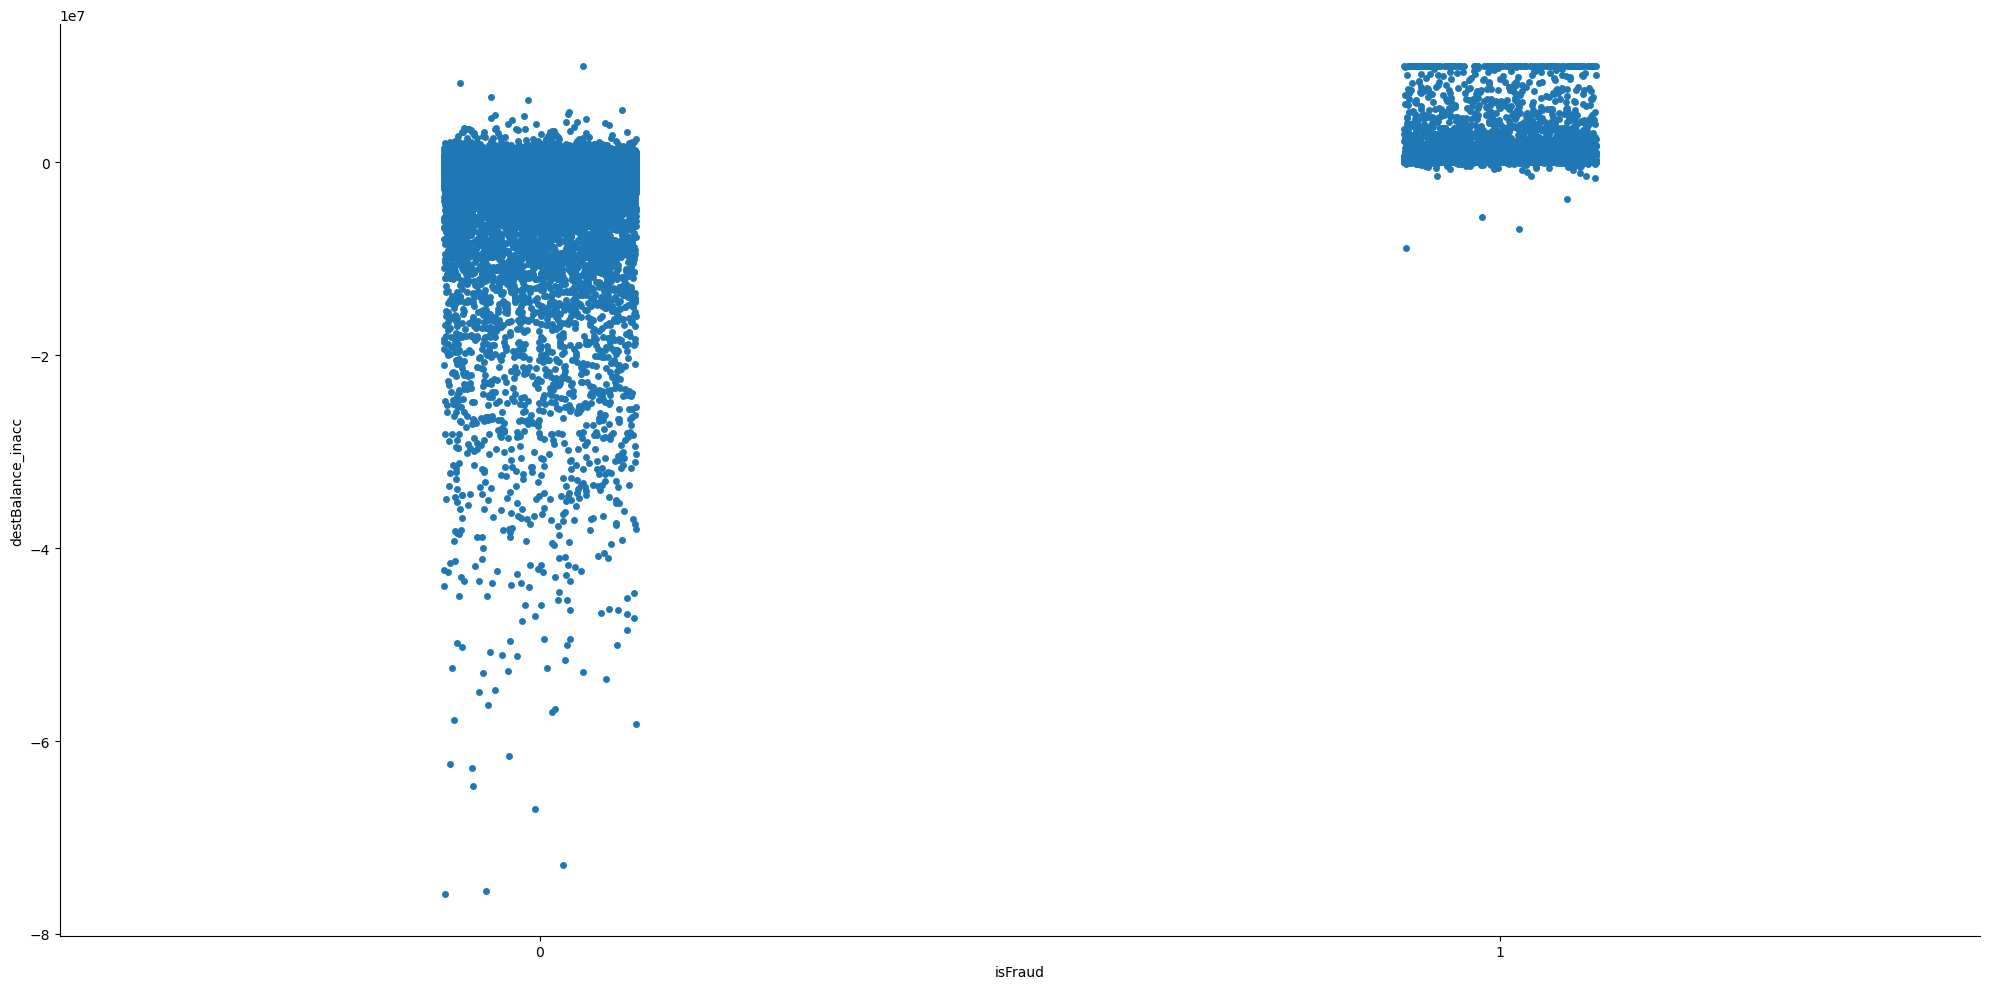

In [400]:
plt.figure(figsize=(20,5))
sns.catplot(data=df, x = df.isFraud, y = df.destBalance_inacc, height = 10, aspect = 2)
plt.show()

It is safe to say we have found differences in the balance inaccuracies between fraudulent & non-fraudulent transactions.
<br><br>
In conclusion of the EDA, let us plot the explored separation between fraudulent and non-fraudulent transactions with respect to the `time step`, `balances` and `balance inaccuracies`.

<Axes: xlabel='destBalance_inacc', ylabel='step'>

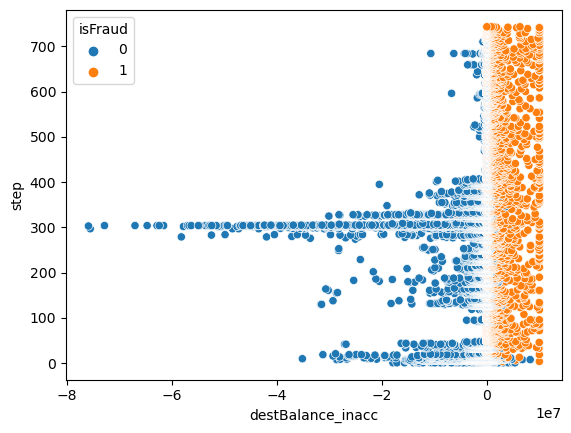

In [401]:
sns.scatterplot(data=df, x = df.destBalance_inacc, y = df.step, hue = df.isFraud)

Calculating the correlation matrix:

/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_29498/3029092044.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


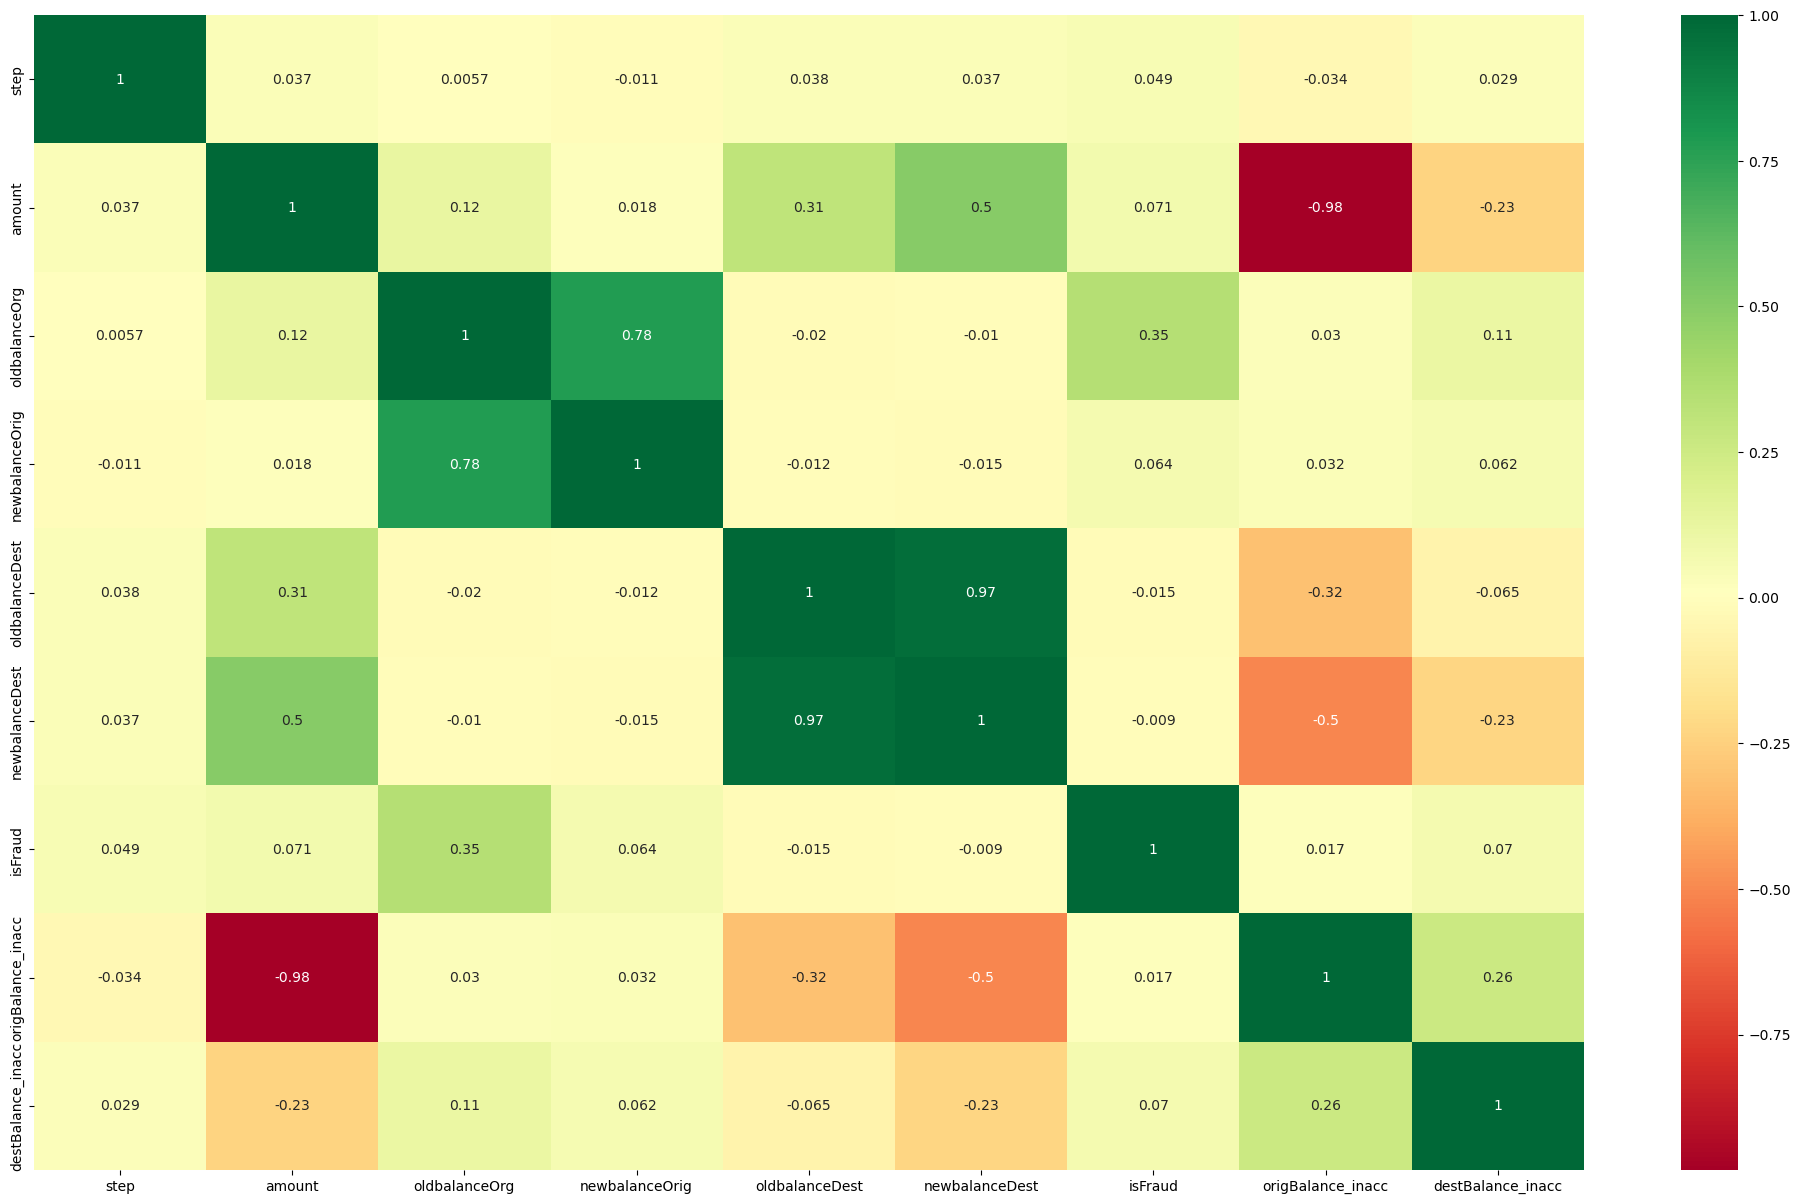

In [402]:
corr = df.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(corr, annot=True, cmap='RdYlGn')
plt.show()

### Modeling

We first need to drop unnecessary variables.

In [403]:
df.drop(['newbalanceDest', 'newbalanceOrig', 'nameOrig', 'nameDest'], axis = 1, inplace = True)

/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_29498/399719482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['newbalanceDest', 'newbalanceOrig', 'nameOrig', 'nameDest'], axis = 1, inplace = True)


Then we move on to `one hot encoding` our categorical variable `type`.

In [404]:
df = pd.get_dummies(df, columns=['type'], prefix=['type'])
df.dtypes

step                   int64
amount               float64
oldbalanceOrg        float64
oldbalanceDest       float64
isFraud                int64
origBalance_inacc    float64
destBalance_inacc    float64
type_CASH_OUT          uint8
type_TRANSFER          uint8
dtype: object

We now need to normalize/standarize our data to scale all columns into the same range.

In [430]:
# from sklearn.preprocessing import StandardScaler

# std_scaler = StandardScaler()
# dfTemp = df.loc[:,~df.columns.isin(['isFraud', 'type_CASH_OUT', 'type_TRANSFER'])]

# data_scaled = pd.DataFrame(std_scaler.fit_transform(dfTemp))
# data_scaled.columns = ['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest','origBalance_inacc', 'destBalance_inacc']
# # data_scaled['isFraud'], data_scaled['type_CASH_OUT'], data_scaled['type_TRANSFER'] = df['isFraud'], df['type_CASH_OUT'], df['type_TRANSFER']
# # df_scaled = pd.concat([df, data_scaled], axis = 1)


TypeError: 'Series' object cannot be interpreted as an integer

Now we need to split our data into `train data` and `test data`.

In [435]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='isFraud')
Y = df['isFraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=0)